# Build a Milvus Powered Image Search Engine in Minutes

This notebook illustrates how to build an image search engine from scratch using [Milvus](https://milvus.io/). Milvus is the most advanced open-source vector database built for AI applications and supports nearest neighbor embedding search across tens of millions of entries. We'll go through image search procedures and evaluate the performance. Moreover, we managed to make the core functionality as simple as 15 lines of code, with which you can start hacking your own image search engine.

## Preparation

### Prepare the data

First, we need to prepare the dataset and Milvus environment. A subset of the ImageNet dataset (100 classes, 10 images for each class) is used in this demo, and the dataset is available via [Google Drive](https://drive.google.com/file/d/1lRhHODcFXUEHf7n-GFlvYgBikhg81KbB/view?usp=sharing) and [Github](https://github.com/towhee-io/data/raw/main/image/reverse_image_search.zip). 

The dataset is organized as follows:
- **train**: directory of candidate images;
- **test**: directory of the query images;
- **reverse_image_search.csv**: a csv file containing an ***id***, ***path***, and ***label*** for each image;

Let's take a quick look:

In [1]:
! curl -L https://github.com/towhee-io/data/raw/main/image/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  119M  100  119M    0     0  8637k      0  0:00:14  0:00:14 --:--:-- 15.4M


In [2]:
import pandas as pd

df = pd.read_csv('reverse_image_search.csv')
df.head()

id                                     path        label
0   0  ./train/brain_coral/n01917289_1783.JPEG  brain_coral
1   1  ./train/brain_coral/n01917289_4317.JPEG  brain_coral
2   2   ./train/brain_coral/n01917289_765.JPEG  brain_coral
3   3  ./train/brain_coral/n01917289_1079.JPEG  brain_coral
4   4  ./train/brain_coral/n01917289_2484.JPEG  brain_coral

To use the dataset for image search, let's first define some helper functions:

- **read_images(results)**: read images by image IDs;
- **ground_truth(path)**: ground-truth for each query image, which is used for calculating mHR(mean hit ratio) and mAP(mean average precision);

In [3]:
import cv2
from towhee._types.image import Image

id_img = df.set_index('id')['path'].to_dict()
label_ids = {}
for label in set(df['label']):
    label_ids[label] = list(df[df['label']==label].id)

def read_images(results):
    imgs = []
    for re in results:
        path = id_img[re.id]
        imgs.append(Image(cv2.imread(path), 'BGR'))
    return imgs

def ground_truth(path):
    label = path.split('/')[-2]
    return label_ids[label]

### Create a Milvus Collection

Before getting started, please make sure you have [installed milvus](https://milvus.io/docs/v2.0.x/install_standalone-docker.md). Let's first create a `reverse_image_search` collection that uses the [L2 distance metric](https://milvus.io/docs/v2.0.x/metric.md#Euclidean-distance-L2) and an [IVF_FLAT index](https://milvus.io/docs/v2.0.x/index.md#IVF_FLAT).

In [4]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":2048}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

## Reverse Image Search

In this section, we'll show how to build our image search engine using Milvus. The basic idea behind semantic image search is the extract embeddings from images using a deep neural network and compare the embeddings with those stored in Milvus.

We use [Towhee](https://towhee.io/), a machine learning framework that allows for creating data processing pipelines. [Towhee](https://towhee.io/) also provides predefined operators which implement insert and query operation in Milvus.

<img src="./workflow.png" width = "60%" height = "60%" align=center />

### Load Image Embeddings into Milvus

We first extract embeddings from images with `resnet50` model and insert the embeddings into Milvus for indexing. Towhee provides a [method-chaining style API](https://towhee.readthedocs.io/en/main/index.html) so that users can assemble a data processing pipeline with operators. 

In [5]:
import towhee

In [7]:
%%time
collection = create_milvus_collection('reverse_image_search', 2048)

dc = (
    towhee.read_csv('reverse_image_search.csv')
      .runas_op['id', 'id'](func=lambda x: int(x))
      .image_decode['path', 'img']()
      .image_embedding.timm['img', 'vec'](model_name='resnet50')
      .to_milvus['id', 'vec'](collection=collection, batch=100)
)

CPU times: user 1min 33s, sys: 5.33 s, total: 1min 38s
Wall time: 19.7 s


In [8]:
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 1000.


#### Explanation of Data Processing Pipeline

Here is detailed explanation for each line of the code:

- `towhee.read_csv('reverse_image_search.csv')`: read tabular data from csv file (`id`, `path` and `label` columns);

- `.runas_op['id', 'id'](func=lambda x: int(x))`: for each row from the data, convert the data type of the column `id` from `str` to `int`;

- `.image_decode['path', 'img']()`: for each row from the data, read and decode the image at `path` and put the pixel data into column `img`;

- `.image_embedding.timm['img', 'vec'](model_name='resnet50')`: extract embedding feature with `image_embedding.timm`, an operator from the [Towhee hub](https://towhee.io/image-embedding/timm) based on [pytorch-image-models](https://github.com/rwightman/pytorch-image-models). This operator supports a variety of image models trained on [ImageNet](https://image-net.org/), including `vgg16`, `resnet50`, `vit_base_patch8_224`, `convnext_base`, etc. 

- `.to_milvus['id', 'vec'](collection=collection, batch=100)`: insert image embedding features in to Milvus;

Below, we decompose the pipeline into stages to get a more intuitive understanding of what's going on

1. read data from csv, get a tabular data with three columns:

In [9]:
towhee.read_csv('reverse_image_search.csv').show()

2. decode and load images from the `path` column into a newly created `img` column:


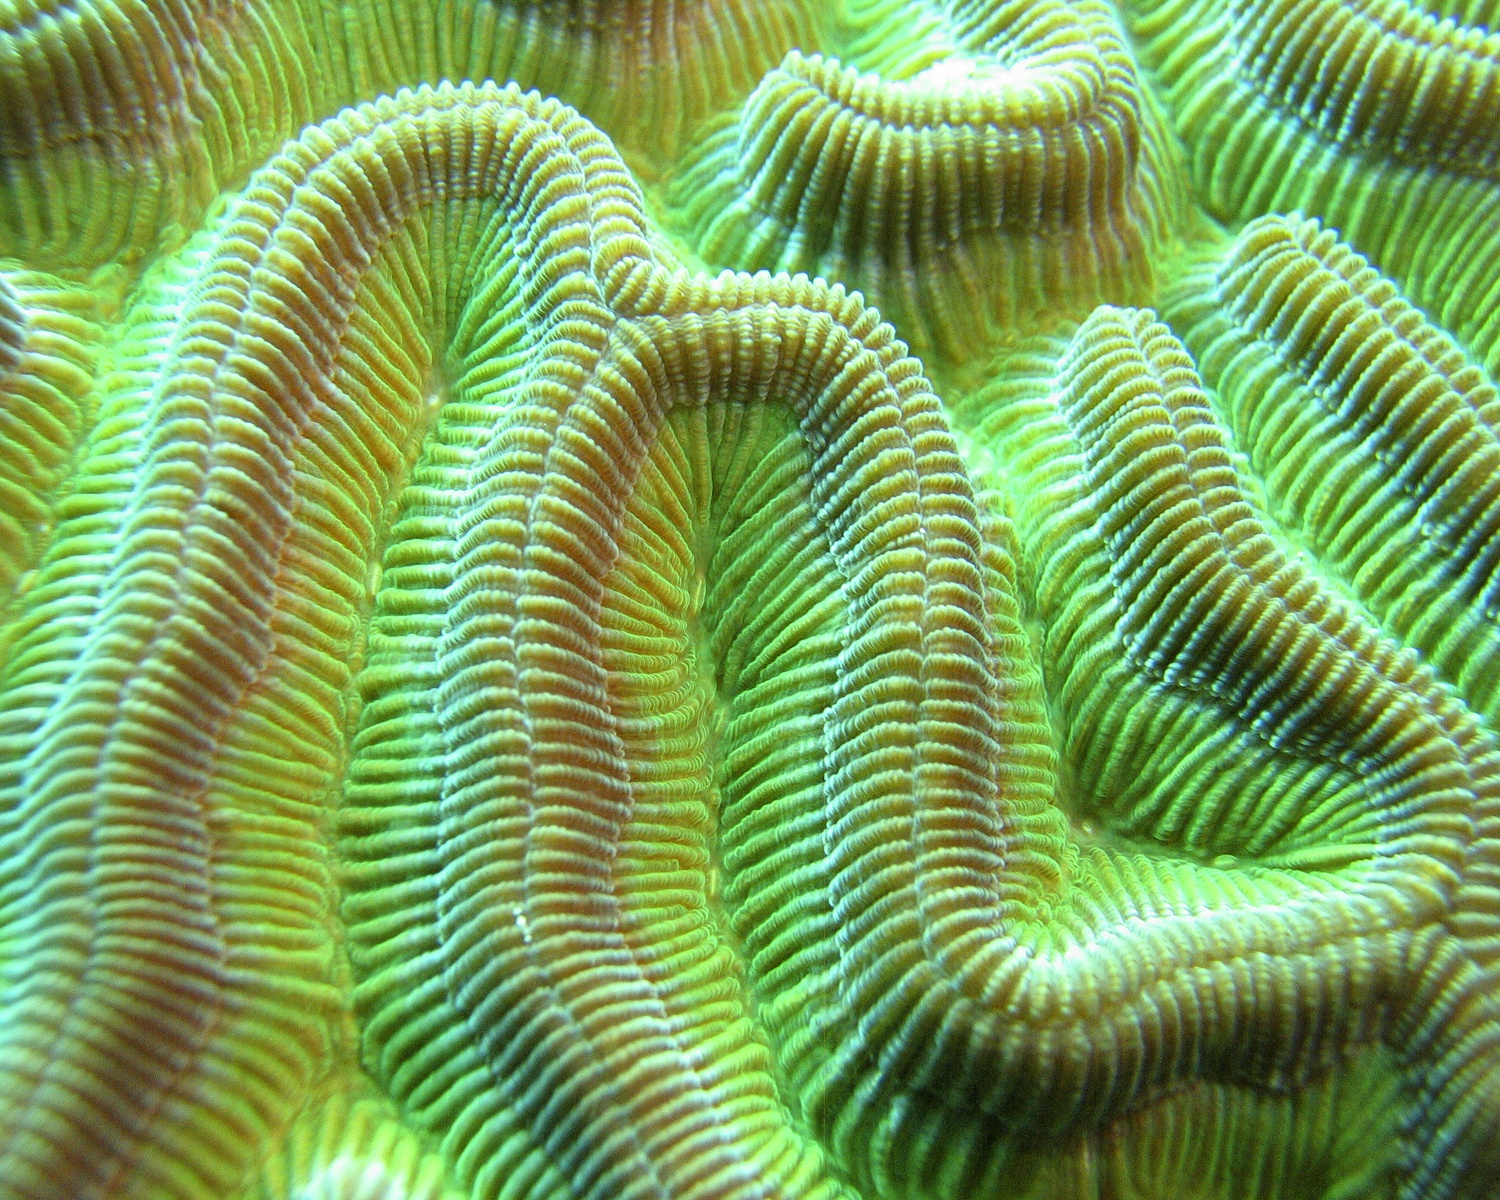
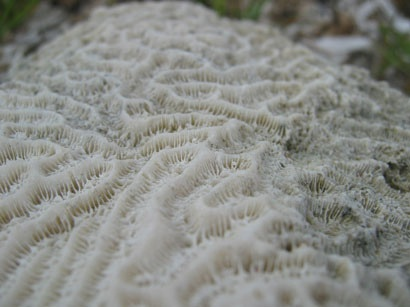

In [10]:
towhee.read_csv('reverse_image_search.csv') \
      .head(2) \
      .image_decode['path', 'img']() \
      .show()

3. extract embedding features using `image_embedding.timm`:


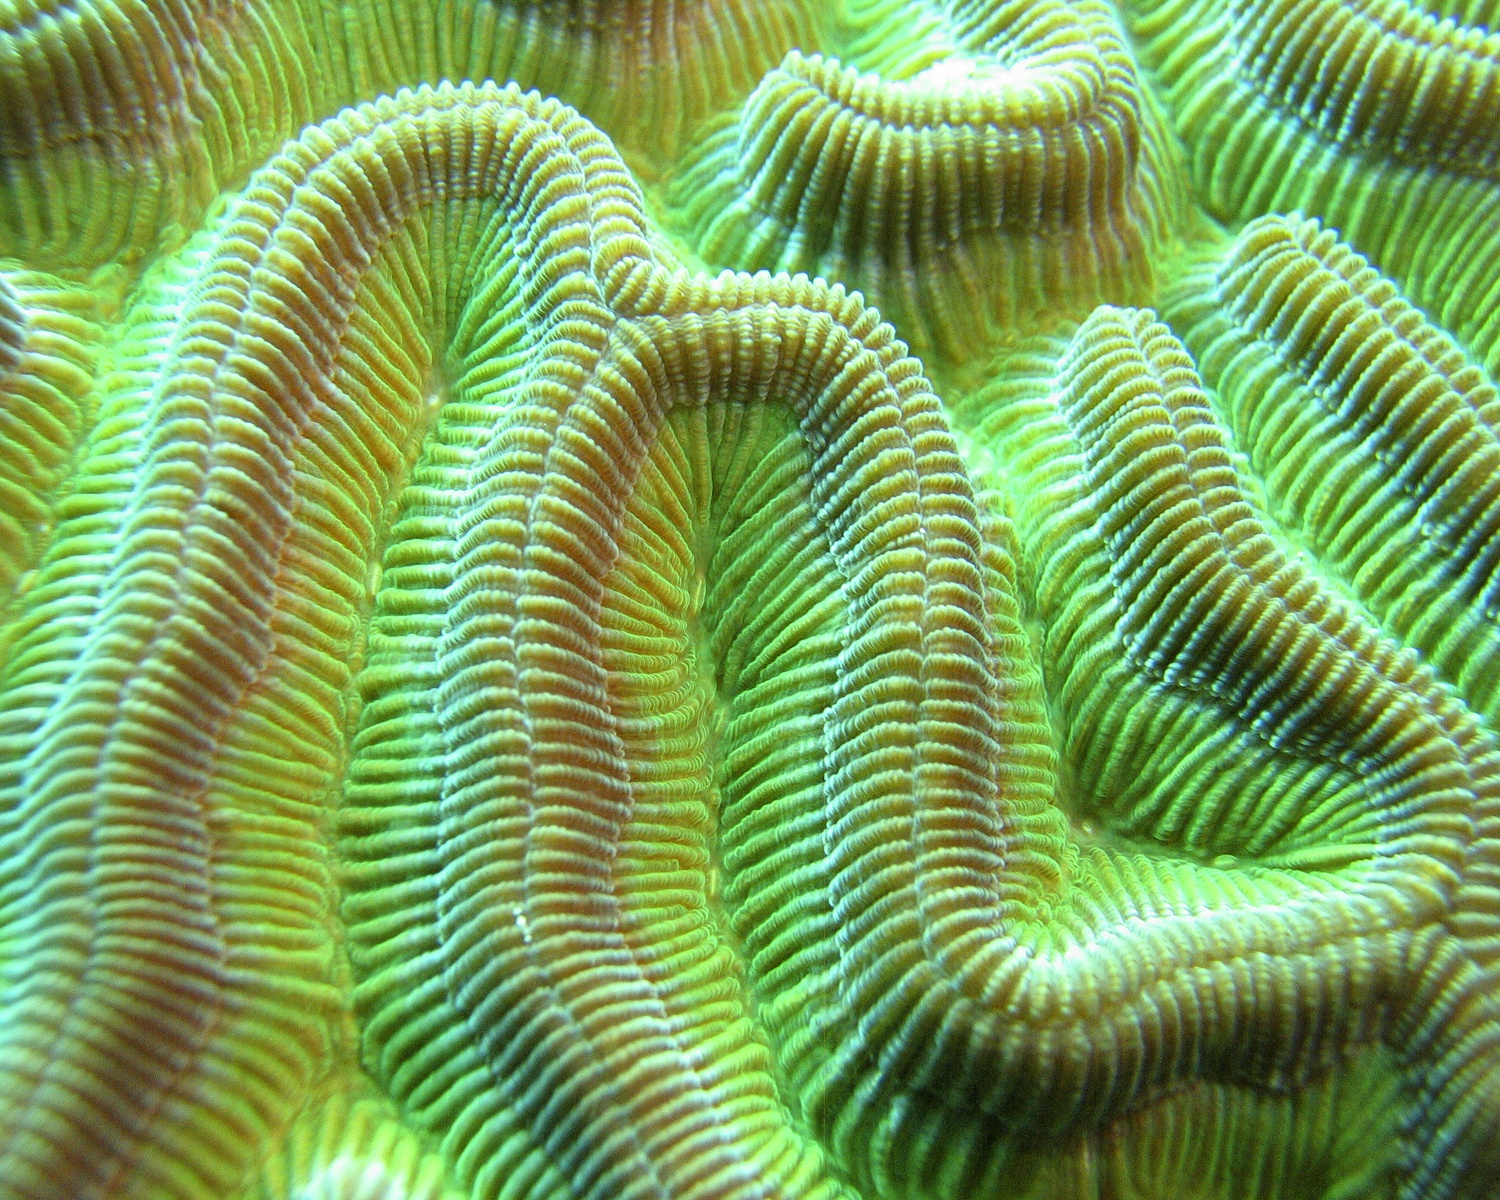
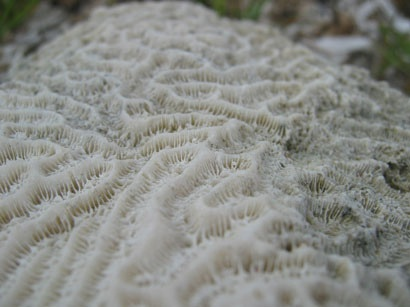

In [11]:
towhee.read_csv('reverse_image_search.csv') \
      .head(2) \
      .image_decode['path', 'img']() \
      .image_embedding.timm['img', 'vec'](model_name='resnet50') \
      .show()

### Query Similar Images from Milvus

Now that embeddings for candidate images have been inserted into Milvus, we can query across it for nearest neighbors. Again, we use Towhee to load the input image, compute an embedding vector, and use the vector as a query for Milvus. Because Milvus only outputs image IDs and distance values, we provide a `read_images` function to get the original image based on IDs and display.


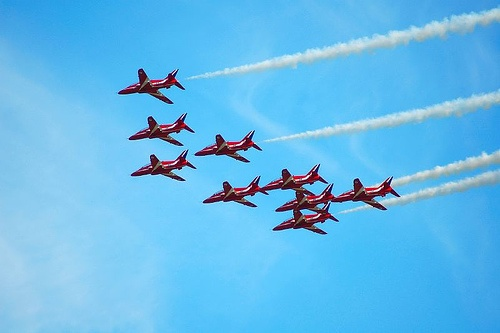
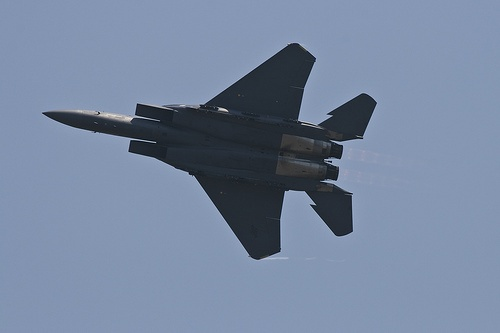
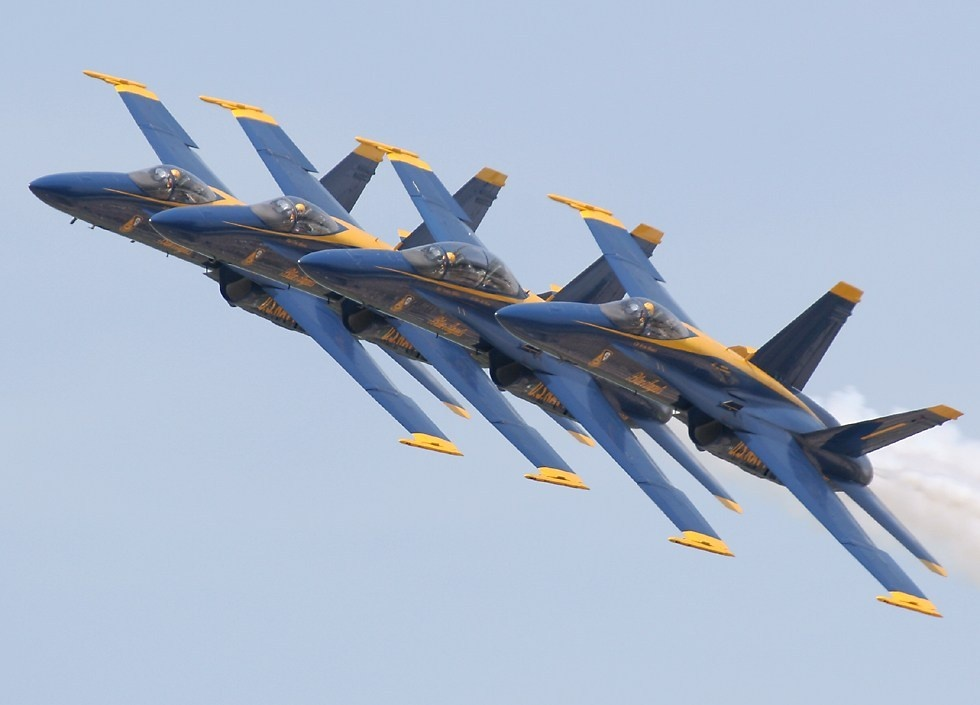
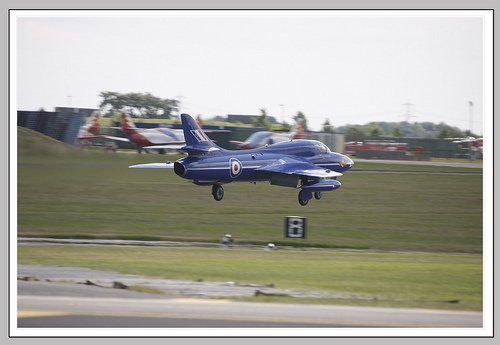
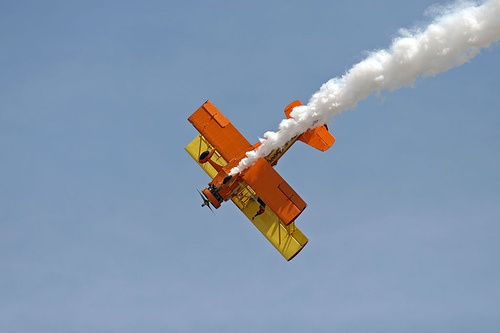
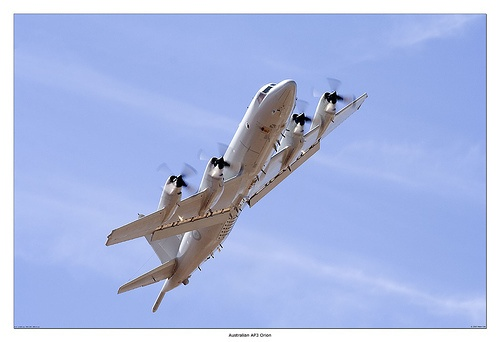
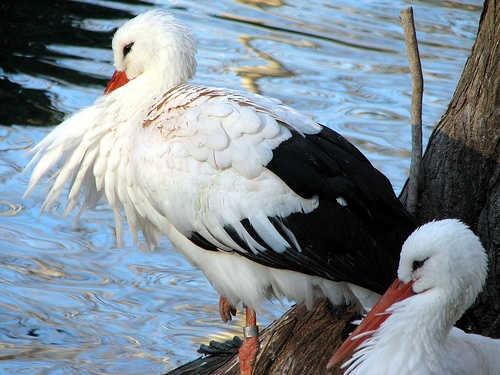
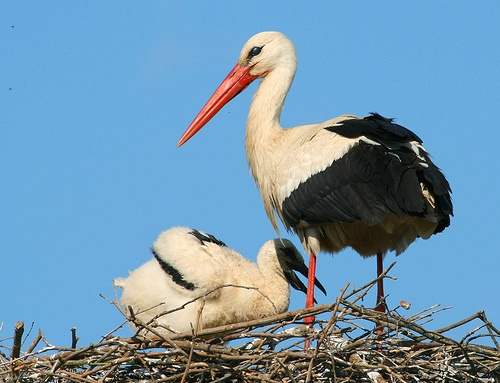
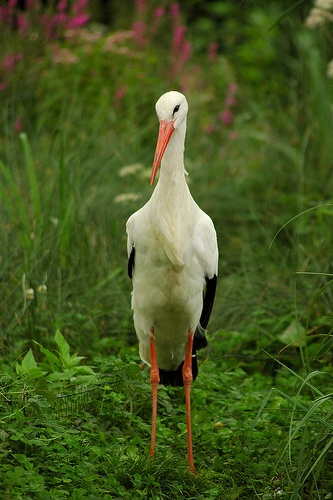
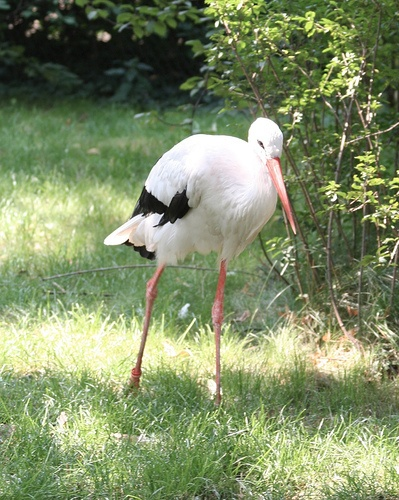
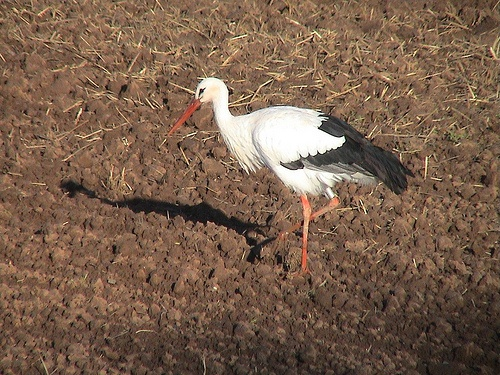
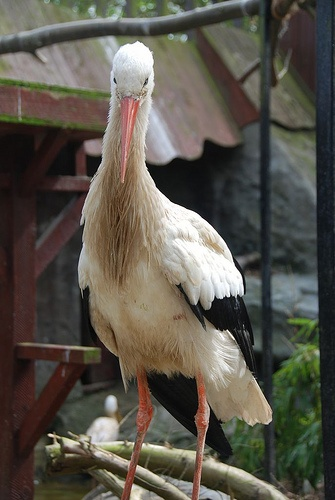
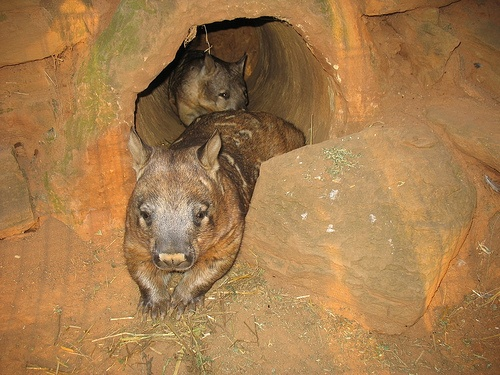
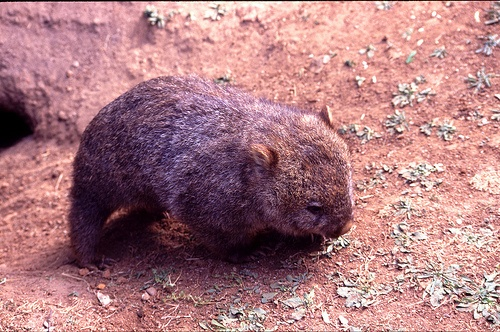
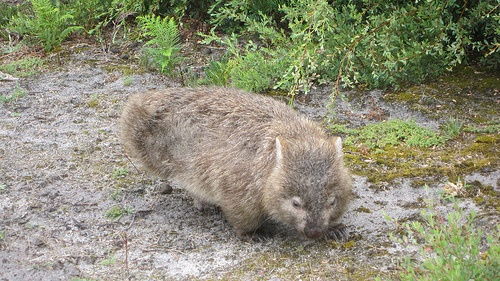
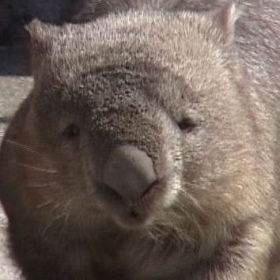
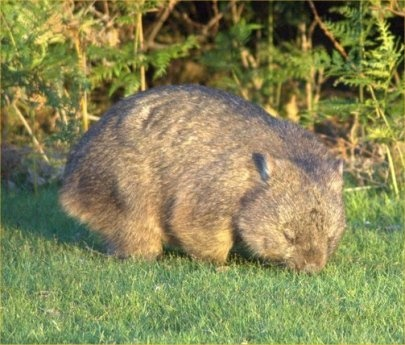
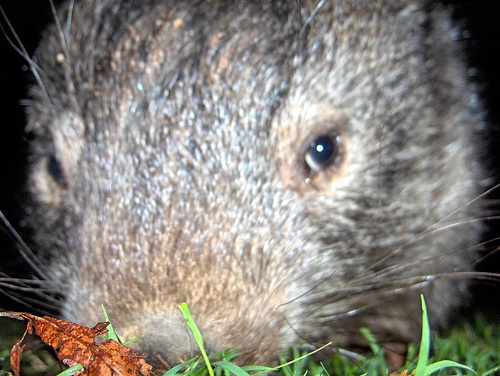

In [12]:
(
    towhee.glob['path']('./test/w*/*.JPEG')
      .image_decode['path', 'img']()
      .image_embedding.timm['img', 'vec'](model_name='resnet50')
      .milvus_search['vec', 'result'](collection=collection, limit=5)
      .runas_op['result', 'result_img'](func=read_images)
      .select['img', 'result_img']()
      .show()
)

## Evaluation

We have finished the core functionality of the image search engine. However, we don't know whether it achieves a reasonable performance. We need to evaluate the search engine against the ground truth so that we know if there is any room to improve it.

In this section, we'll evaluate the strength of our image search engine using mHR and mAP:
- [mHR (recall@K)](https://amitness.com/2020/08/information-retrieval-evaluation/#2-recallk): This metric describes how many actual relevant results were returned out of all ground-truth relevant results by the search engine. For example, if we have put 100 pictures of cats into the search engine and then query the image search engine with another picture of cats. The total relevant result is 100, and the actual relevant results are the number of cat images in the top 100 results returned by the search engine. If there are 80 images about cats in the search result, the hit ratio is 80/100;
- [mAP](https://amitness.com/2020/08/information-retrieval-evaluation/#3-mean-average-precisionmap): Average precision describes whether all of the relevant results are ranked higher than irrelevant results.

In [13]:
%%time
benchmark = (
    towhee.glob['path']('./test/*/*.JPEG')
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet50')
        .milvus_search['vec', 'result'](collection=collection, limit=10)
        .runas_op['path', 'ground_truth'](func=ground_truth)
        .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
        .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
        .evaluate['ground_truth', 'result']('resnet50')
        .report()
)

mean_hit_ratio  mean_average_precision
resnet50           0.687                 0.88655

CPU times: user 10.8 s, sys: 1.06 s, total: 11.9 s
Wall time: 3.2 s


The mean HR of all the queries is 0.687 (not a great result). Let's optimize it further.

### Optimization I: embedding vector normalization

A quick optimization is normalizing the embedding features before indexing them in Milvus. This results in _cosine similarity_, which measures the similarity between two vectors using the angle between them while ignoring the magnitude of the vectors.

In [14]:
%%time
collection = create_milvus_collection('reverse_image_search_norm', 2048)

dc = (
    towhee.read_csv('reverse_image_search.csv')
      .runas_op['id', 'id'](func=lambda x: int(x))
      .image_decode['path', 'img']()
      .image_embedding.timm['img', 'vec'](model_name='resnet50')
      .tensor_normalize['vec', 'vec']()
      .to_milvus['id', 'vec'](collection=collection, batch=100)
)

CPU times: user 1min 31s, sys: 5.03 s, total: 1min 36s
Wall time: 18.5 s


In [15]:
%%time
benchmark = (
    towhee.glob['path']('./test/*/*.JPEG')
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet50')
        .tensor_normalize['vec', 'vec']()
        .milvus_search['vec', 'result'](collection=collection, limit=10)
        .runas_op['path', 'ground_truth'](func=ground_truth)
        .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
        .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
        .evaluate['ground_truth', 'result']('resnet50')
        .report()
)

mean_hit_ratio  mean_average_precision
resnet50           0.781                0.917373

CPU times: user 10.1 s, sys: 604 ms, total: 10.7 s
Wall time: 2.98 s


By normalizing the embedding features, the mean HR shoots up to 0.781.

### Optimization II: increase model complexity

Another quick optimization is increase model complexity (at the cost of runtime). With Towhee, this is very easy: we simply replace Resnet-50 with [EfficientNet-B7](https://pytorch.org/vision/stable/models.html#classification), an image classificiation model which has better accuracy on ImageNet. Although Towhee provides a pre-trained EfficientNet-B7 model via `timm`, we'll use `torchvision` to demonstrate how external models and functions can be used within Towhee.

In [16]:
import torch
import towhee
from torchvision import models
from torchvision import transforms
from PIL import Image as PILImage


torch_model = models.efficientnet_b7(pretrained=True)
torch_model = torch.nn.Sequential(*(list(torch_model.children())[:-1]))
torch_model.to('cuda' if torch.cuda.is_available() else 'cpu')
torch_model.eval()
preprocess = transforms.Compose([
    transforms.Resize(size=224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def efficientnet_b7(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = PILImage.fromarray(img.astype('uint8'), 'RGB')
    img = torch.unsqueeze(preprocess(img), 0)
    img = img.to('cuda' if torch.cuda.is_available() else 'cpu')
    embedding = torch_model(img).detach().cpu().numpy()
    return embedding.reshape([2560])

In [17]:
%%time
collection = create_milvus_collection('image_search_efficientnet_b7', 2560)

dc = (
    towhee.read_csv('reverse_image_search.csv')
        .runas_op['id', 'id'](func=lambda x: int(x))
        .image_decode['path', 'img']()
        .runas_op['img', 'vec'](func=efficientnet_b7)
        .tensor_normalize['vec', 'vec']()
        .to_milvus['id', 'vec'](collection=collection, batch=100)
    )

CPU times: user 1min 57s, sys: 4.6 s, total: 2min 1s
Wall time: 39.9 s


In [18]:
%%time
benchmark = (
    towhee.glob['path']('./test/*/*.JPEG')
        .image_decode['path', 'img']()
        .runas_op['img', 'vec'](func=efficientnet_b7)
        .tensor_normalize['vec', 'vec']()
        .milvus_search['vec', 'result'](collection=collection, limit=10)
        .runas_op['path', 'ground_truth'](func=ground_truth)
        .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
        .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
        .evaluate['ground_truth', 'result']('efficientnet_b7')
        .report()
)

mean_hit_ratio  mean_average_precision
efficientnet_b7           0.878                0.954662

CPU times: user 12 s, sys: 577 ms, total: 12.5 s
Wall time: 4.94 s


By replacing Resnet50 with EfficientNet-B7, the mean HR is raised to 0.878! But the data processing pipeline also gets much slower and takes 28% more time.

This illustrates how to use a PyTorch model from torch hub. You can follow the code when testing your own model against the benchmark.

## Release a Showcase

We've done an excellent job on the core functionality of our image search engine. Now it's time to build a showcase with interface. [Gradio](https://gradio.app/) is a great tool for building demos. With Gradio, we simply need to wrap the data processing pipeline via a `search_in_milvus` function:

In [19]:
from towhee.types.image_utils import from_pil

with towhee.api() as api:
    milvus_search_function = (
        api.runas_op(func=lambda img: from_pil(img))
            .image_embedding.timm(model_name='resnet50')
            .tensor_normalize()
            .milvus_search(collection='reverse_image_search_norm', limit=5)
            .runas_op(func=lambda res: [id_img[x.id] for x in res])
            .as_function()
    )

In [20]:
import gradio

interface = gradio.Interface(milvus_search_function, 
                             gradio.inputs.Image(type="pil", source='upload'),
                             [gradio.outputs.Image(type="file", label=None) for _ in range(5)]
                            )

interface.launch(inline=True, share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://44179.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fc22000ca60>,
 'http://127.0.0.1:7860/',
 'https://44179.gradio.app')